# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png)

##  Project Capstone

### Reducing Electricity Costs in Romania: Predictive and Reinforcement Learning for Solar Battery Optimization

---

[README](../README.md) | [Part 1: Cleaning](01_Cleaning.ipynb) | [Part 2: EDA](02_EDA.ipynb) | [Part 3: Solar Energy Prediction Models](03_Model_Solar_Energy.ipynb) | [Part 4: Electricity Cost Prediction Models](04_Model_Electricity_Cost.ipynb) | [Part 5: Electricity Cost Prediction Using Time Series Models](05_Model_Electricity_Cost_ts.ipynb) | **Part 6: Solar Battery Optimization**

---

### Introduction
- A solar battery is a device that stores energy generated by solar panels for later use.
- **Charging** a solar battery involves storing excess energy generated by the solar panel. When a solar battery is charging, it is in a state of receiving energy and cannot simultaneously discharge or supply power to the system.
- **Discharging** occurs when the stored energy in the solar battery is used to supply power to the system. When a solar battery is discharging, it cannot simultaneously charge as it is in a state of providing energy.
- An optimization model using reinforcement learning will be designed to minimize electricity costs, considering the predicted solar power availability and electricity prices for each hour. The model will learn when to charge or discharge the solar battery based on the current state, optimizing the use of stored energy to ensure efficiency and cost-effectiveness.

### Assumption
- According to [Romania Total Energy Consumption](https://www.enerdata.net/estore/energy-market/romania/#:~:text=Romania%20Total%20Energy%20Consumption,again%20by%207.7%25%20in%202022.), the electricity consumption per capita is 2,300 kWh per year. Therefore, the average electricity usage per household of two people is approximately 13 kWh per day.
- According to [The Evolution of Romania's solar PV Market](https://rpia.ro/wp-content/uploads/2024/03/The-evolution-of-the-PV-market-in-Romania-in-2023.pdf?form=MG0AV3), as of 2023, the country has installed over 2.85 GW of solar capacity.
- According to [Romania's Rooftop Country Profile](https://caneurope.org/content/uploads/2024/04/Romania-Residental-Rooftop-Solar-Country-Profile.pdf?form=MG0AV3), households typically have solar panel sizes of 3 to 5 kW.

### Import

#### Essential Libraries

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
np.random.seed(42)

#### Import Data

In [3]:
df = pd.read_csv('../data/cleaned/electricity_romania.csv')       # Import
df['datetime'] = pd.to_datetime(df['datetime'])                   # Formatting `datetime`
df['month'] = df['datetime'].dt.month                             # Extract month
df['hour'] = df['datetime'].dt.hour                               # Extract hour
df['day'] = df['datetime'].dt.day                                 # Extract day

### Environment
- The electricity cost by hour is the median of the costs for each hour.
- The solar energy collected by a household is calculated from the proportion of the median solar production (on a country scale) to the household scale.
- The hourly load (hourly demand) is calculated based on the average usage per household, assumed to be 13 kWh per day. This demand is distributed according to three patterns: 1. Uniform, 2. Peak-hour usage, and 3. Non-peak hour usage.
  - Uniform: Energy usage is evenly distributed across all hours of the day.
  - Peak-hour usage: Energy usage is higher during peak hours, reflecting typical household consumption patterns.
  - Non-peak hour usage: Energy usage varies unpredictably and does not follow a consistent pattern.

In [5]:
# Electricity Cost by Hour
env = pd.DataFrame(df['ckwh'].groupby(df['hour']).median())

In [7]:
# Solar Energy Collected by Hour

# Daily Solar Energy Collected by Romania
daily_solar_romania = df['solar'].groupby(df['hour']).median().sum()

# Proportion to Household Scale (Solar Panel of 5 kW)
daily_solar_household = daily_solar_romania / 2850 * 5

print(f'Household Daily Solar Energy Collected: {daily_solar_household:.2f} kW')

Household Daily Solar Energy Collected: 5.80 kW


In [9]:
env['solar'] = df['solar'].groupby(df['hour']).median() / daily_solar_romania * daily_solar_household

In [41]:
# Uniform
env['load_uniform'] = 13 / 24
# Peak Hour
env['load_peak'] = env['ckwh'] * (13 / env['ckwh'].sum())
# Non Peak Hour
env['load_non_peak'] = (1 / env['ckwh']) * (13 / (1 / env['ckwh']).sum())

In [45]:
env.sum()

ckwh             179.335000
solar              5.799123
load_uniform      13.000000
load_peak         13.000000
load_non_peak     13.000000
dtype: float64

In [51]:
env

,ckwh,solar,load_uniform,load_peak,load_non_peak
hour,,,,,
0,7.240,0.000000,0.541667,0.524828,0.540989
1,6.890,0.000000,0.541667,0.499456,0.568470
2,6.415,0.000000,0.541667,0.465024,0.610563
3,6.110,0.000000,0.541667,0.442914,0.641041
4,5.955,0.000000,0.541667,0.431678,0.657726
5,5.855,0.000000,0.541667,0.424429,0.668960
6,6.050,0.000000,0.541667,0.438565,0.647398
7,6.860,0.003509,0.541667,0.497282,0.570956
8,8.005,0.147368,0.541667,0.580283,0.489289


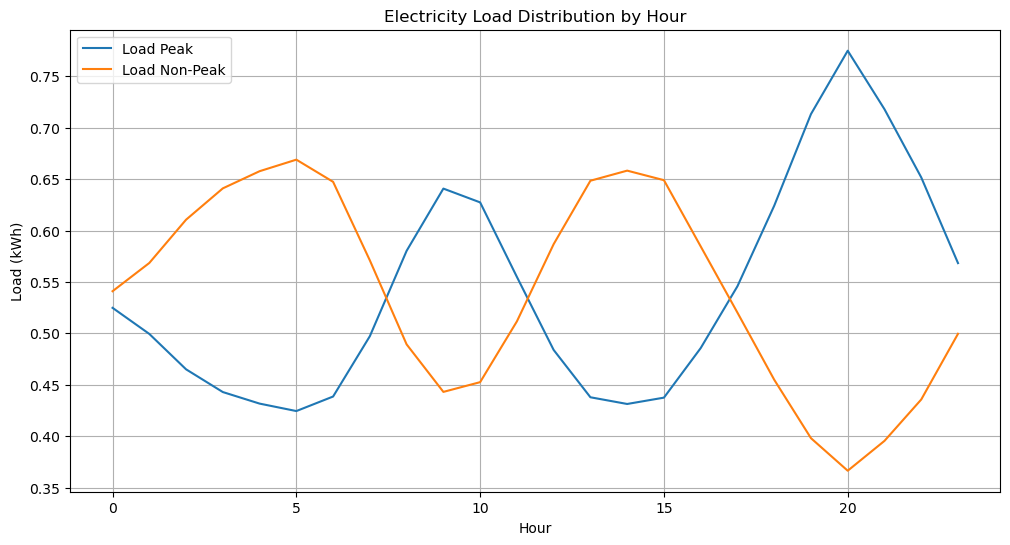

In [53]:


# Plotting load_peak and load_non_peak
plt.figure(figsize=(12, 6))
plt.plot(env.index, env['load_peak'], label='Load Peak')
plt.plot(env.index, env['load_non_peak'], label='Load Non-Peak')

# Adding labels and title
plt.xlabel('Hour')
plt.ylabel('Load (kWh)')
plt.title('Electricity Load Distribution by Hour')
plt.legend()
plt.grid(True)
plt.show()


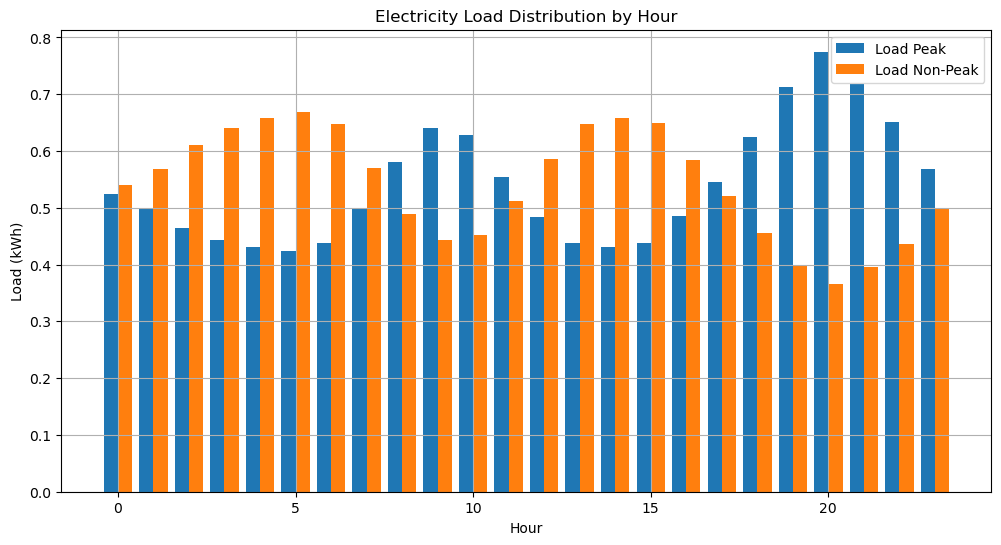

In [55]:
import matplotlib.pyplot as plt

# Plotting load_peak and load_non_peak as bar charts
plt.figure(figsize=(12, 6))

# Bar plot for load_peak
plt.bar(env.index - 0.2, env['load_peak'], width=0.4, label='Load Peak', align='center')

# Bar plot for load_non_peak
plt.bar(env.index + 0.2, env['load_non_peak'], width=0.4, label='Load Non-Peak', align='center')

# Adding labels and title
plt.xlabel('Hour')
plt.ylabel('Load (kWh)')
plt.title('Electricity Load Distribution by Hour')
plt.legend()
plt.grid(True)
plt.show()


In [133]:
Q

{(0, 0): {0: 1, 1: 1},
 (0, 1): {0: 1, 1: 1},
 (0, 2): {0: 1, 1: 1},
 (0, 3): {0: 1, 1: 1},
 (0, 4): {0: 1, 1: 1},
 (0, 5): {0: 1, 1: 1},
 (0, 6): {0: 1, 1: 1},
 (0, 7): {0: 1, 1: 1},
 (0, 8): {0: 1, 1: 1},
 (0, 9): {0: 1, 1: 1},
 (0, 10): {0: 1, 1: 1},
 (0, 11): {0: 1, 1: 1},
 (0, 12): {0: 1, 1: 1},
 (0, 13): {0: 1, 1: 1},
 (0, 14): {0: 1, 1: 1},
 (0, 15): {0: 1, 1: 1},
 (0, 16): {0: 1, 1: 1},
 (0, 17): {0: 1, 1: 1},
 (0, 18): {0: 1, 1: 1},
 (0, 19): {0: 1, 1: 1},
 (0, 20): {0: 1, 1: 1},
 (0, 21): {0: 1, 1: 1},
 (0, 22): {0: 1, 1: 1},
 (0, 23): {0: 1, 1: 1},
 (0, 24): {0: 1, 1: 1},
 (0, 25): {0: 1, 1: 1},
 (0, 26): {0: 1, 1: 1},
 (0, 27): {0: 1, 1: 1},
 (0, 28): {0: 1, 1: 1},
 (0, 29): {0: 1, 1: 1},
 (0, 30): {0: -46.473832192336076, 1: -46.51540080693547},
 (0, 31): {0: 1, 1: 1},
 (0, 32): {0: 1, 1: 1},
 (0, 33): {0: 1, 1: 1},
 (0, 34): {0: 1, 1: 1},
 (0, 35): {0: 1, 1: 1},
 (0, 36): {0: 1, 1: 1},
 (0, 37): {0: 1, 1: 1},
 (0, 38): {0: 1, 1: 1},
 (0, 39): {0: 1, 1: 1},
 (0, 40): {0: 1

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize Q-table as a dictionary
Q = {}
for x in range(24):  # x ranges from 0 to 23
    for y in range(101):  # y ranges from 0 to 100
        Q[(x, y)] = {action: -10 for action in [0, 1]}

# Hyperparameters
alpha = 0.1  # Learning rate 0.1
gamma = 0.99  # Discount factor 0.9
min_epsilon = 0.1  # Minimum exploration rate
initial_epsilon = 1  # Initial exploration rate
decay_rate = 0.999  # Decay rate for epsilon
num_episodes = 100000  # Number of episodes
max_battery = 100  # Maximum battery capacity
threshold = 1e-12
threshold_counter = 0

# Sample data for simulation (replace with actual data)
electricity_price_per_unit = np.concatenate([
    np.random.randint(1, 6, size=12), 
    np.random.randint(6, 11, size=12)
])
solar_power_generation = np.concatenate([
    np.zeros(6), 
    np.random.randint(1, 11, size=12), 
    np.zeros(6)
])
electricity_demand = np.concatenate([
    np.random.randint(3, 12, size=6), 
    np.random.randint(12, 20, size=12), 
    np.random.randint(3, 12, size=6)
])

# ε-greedy policy function
def epsilon_greedy_policy(state, Q, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice([0, 1])  # Explore: choose a random action
    else:
        return max(Q[state], key=Q[state].get)  # Exploit: choose best action based on Q-values

# Q-Learning algorithm
episode_rewards = []  # List to store the reward for each episode

for episode in range(num_episodes):
    
    state = (0, 30)  # Initial state (time=0, battery=30)
    epsilon = max(min_epsilon, initial_epsilon * (decay_rate ** episode))  # Decay epsilon
    episode_reward = 0  # Track the reward for the episode
    
    while state[0] < 24:  # Ensure the episode ends before reaching time 24
        action = epsilon_greedy_policy(state, Q, epsilon)
        
        if action == 0:  # Charge
            reward = -electricity_price_per_unit[state[0]] * electricity_demand[state[0]]
            next_battery_level = min(max_battery, state[1] + solar_power_generation[state[0]])
        else:  # Discharge
            if state[1] >= electricity_demand[state[0]]:
                reward = 0
                next_battery_level = state[1] - electricity_demand[state[0]]
            else:
                reward = -electricity_price_per_unit[state[0]] * (electricity_demand[state[0]] - state[1])
                next_battery_level = 0
        
        next_state = (state[0] + 1, int(round(next_battery_level)))
        
        # Q-Learning update rule
        if next_state[0] < 24:
            best_next_action = max(Q[next_state], key=Q[next_state].get)
            Q[state][action] += alpha * (reward + gamma * Q[next_state][best_next_action] - Q[state][action])
            if abs(alpha * (reward + gamma * Q[next_state][best_next_action] - Q[state][action])) < threshold:
                threshold_counter += 1
        else:
            # For terminal state, update Q-value using only the immediate reward
            Q[state][action] += alpha * (reward - Q[state][action])
            if abs(alpha * (reward - Q[state][action])) < threshold:
                threshold_counter += 1

        state = next_state
        episode_reward += reward  # Accumulate the reward for the episode
    
    episode_rewards.append(episode_reward)
    print(f"Episode {episode + 1}, epsilon: {epsilon:.4f}, reward: {episode_reward}, {threshold_counter}")
    if threshold_counter > 100000:
        break

Episode 1, epsilon: 1.0000, reward: -1273, 0
Episode 2, epsilon: 0.9990, reward: -1285, 0
Episode 3, epsilon: 0.9980, reward: -1308, 0
Episode 4, epsilon: 0.9970, reward: -1254, 0
Episode 5, epsilon: 0.9960, reward: -1411, 0
Episode 6, epsilon: 0.9950, reward: -1308, 0
Episode 7, epsilon: 0.9940, reward: -1310, 0
Episode 8, epsilon: 0.9930, reward: -1229, 0
Episode 9, epsilon: 0.9920, reward: -1228, 0
Episode 10, epsilon: 0.9910, reward: -1224, 0
Episode 11, epsilon: 0.9900, reward: -1314, 0
Episode 12, epsilon: 0.9891, reward: -1364, 0
Episode 13, epsilon: 0.9881, reward: -1231, 0
Episode 14, epsilon: 0.9871, reward: -1232, 0
Episode 15, epsilon: 0.9861, reward: -1206, 0
Episode 16, epsilon: 0.9851, reward: -1243, 0
Episode 17, epsilon: 0.9841, reward: -1350, 0
Episode 18, epsilon: 0.9831, reward: -1293, 0
Episode 19, epsilon: 0.9822, reward: -1315, 0
Episode 20, epsilon: 0.9812, reward: -1169, 0
Episode 21, epsilon: 0.9802, reward: -1303, 0
Episode 22, epsilon: 0.9792, reward: -1319,

Text(0.5, 1.0, 'Median Rewards vs Episodes')

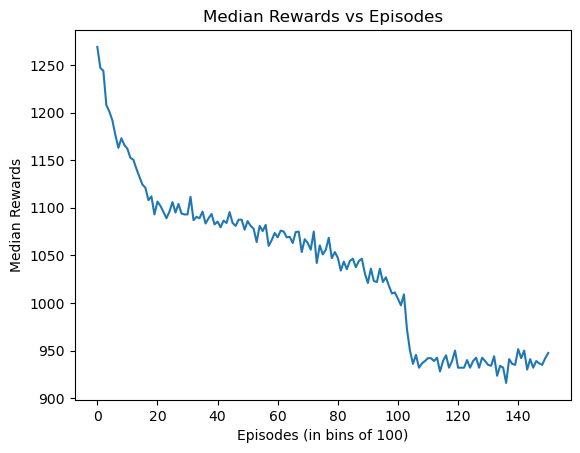

In [25]:
# Calculate medians for bins of 100 episodes 
binned_medians = [-np.median(episode_rewards[i:i + 100]) for i in range(0, len(episode_rewards), 100)] 
# Plotting the binned medians 
plt.plot(binned_medians) 
plt.xlabel('Episodes (in bins of 100)') 
plt.ylabel('Median Rewards') 
plt.title('Median Rewards vs Episodes')

In [31]:
np.max(episode_rewards)

-893